Rate network equations:

$$\mathbf{\tau}\cfrac{d\mathbf{v}}{dt} = -\mathbf{v} + W\phi(\mathbf{v}) + I_{noise}(t) + I_{motion}(t)$$

$$\phi(v) = \cfrac{2}{1 + \exp(-v)} - 1$$




# Noise-driven activity

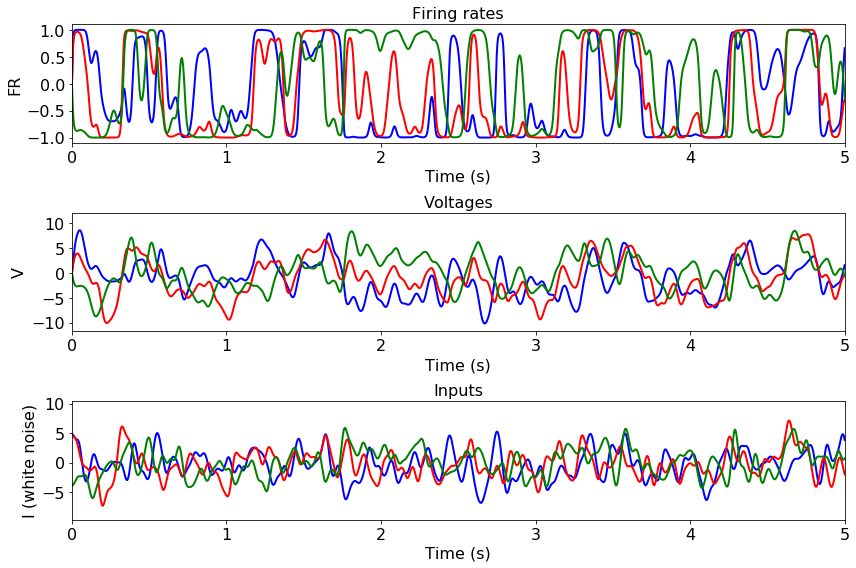

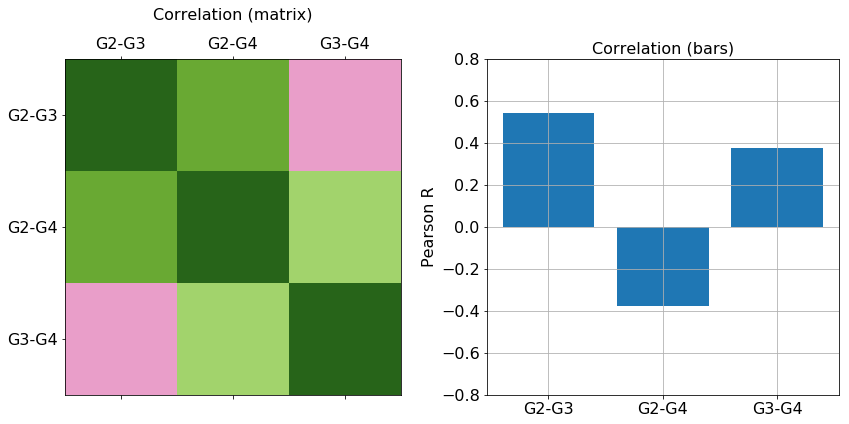

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d as smooth
from scipy.stats import pearsonr

from disp import set_font_size

SEED = 0
TAU = np.array([0.02, 0.02, 0.02])
W = 3*np.array([
#from G2 G3 G4
     [0, 1.1, -1],  # to G2
     [1.1, 0, 1],   # to G3
     [-1, 1, 0],  # to G4
], dtype=float)
G = 1
C = ['b', 'r', 'g']

DT = 0.001  # smln timestep
I_E_SMOOTH_INT = int(round(20*DT/DT))

def phi(x):
    return 2/(1 + np.exp(-x)) - 1

# set up inputs
np.random.seed(SEED)
t = np.arange(0, 50, DT)
n_t = len(t)
i_es = smooth(20*np.random.normal(0, 1, (n_t, 3)), I_E_SMOOTH_INT, axis=0)

# run smln
vs = np.nan * np.zeros((n_t, 3))
rs = np.nan * np.zeros((n_t, 3))

vs[0, :] = 0
rs[0, :] = 0

for ctr, i_e in zip(range(1, n_t), i_es[:-1]):
    v = vs[ctr-1]
    dv = DT/TAU * (-v + W.dot(rs[ctr-1]) + i_e)
    vs[ctr] = v + dv
    rs[ctr] = phi(G*vs[ctr])

fig, axs = plt.subplots(3, 1, figsize=(12, 8), tight_layout=True)

for dan in range(3):
    axs[0].plot(t, rs[:, dan], C[dan], lw=2)
    axs[1].plot(t, vs[:, dan], C[dan], lw=2)
    axs[2].plot(t, i_es[:, dan], C[dan], lw=2)

axs[0].set_title('Firing rates')
axs[0].set_ylabel('FR')
axs[1].set_title('Voltages')
axs[1].set_ylabel('V')
axs[2].set_title('Inputs')
axs[2].set_ylabel('I (white noise)')

for ax in axs:
    ax.set_xlim(0, 5)
    ax.set_xlabel('Time (s)')
    set_font_size(ax, 16)
    
# analysis
xcor = np.corrcoef(rs.T)
r_23 = xcor[0, 1]
r_24 = xcor[0, 2]
r_34 = xcor[1, 2]

fig, axs = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)
axs[0].matshow(xcor, interpolation='nearest', cmap='PiYG', vmin=-.8, vmax=.8)
axs[0].set_xticks([0, 1, 2])
axs[0].set_yticks([0, 1, 2])
axs[0].set_xticklabels(['G2-G3', 'G2-G4', 'G3-G4'])
axs[0].set_yticklabels(['G2-G3', 'G2-G4', 'G3-G4'])
axs[0].set_title('Correlation (matrix)\n')

axs[1].bar(np.arange(3), [r_23, r_24, r_34])
axs[1].set_ylim(-.8, .8)
axs[1].set_ylabel('Pearson R')
axs[1].set_xticks([0, 1, 2])
axs[1].set_xticklabels(['G2-G3', 'G2-G4', 'G3-G4'])
axs[1].set_title('Correlation (bars)')
axs[1].grid()

for ax in axs:
    set_font_size(ax, 16)

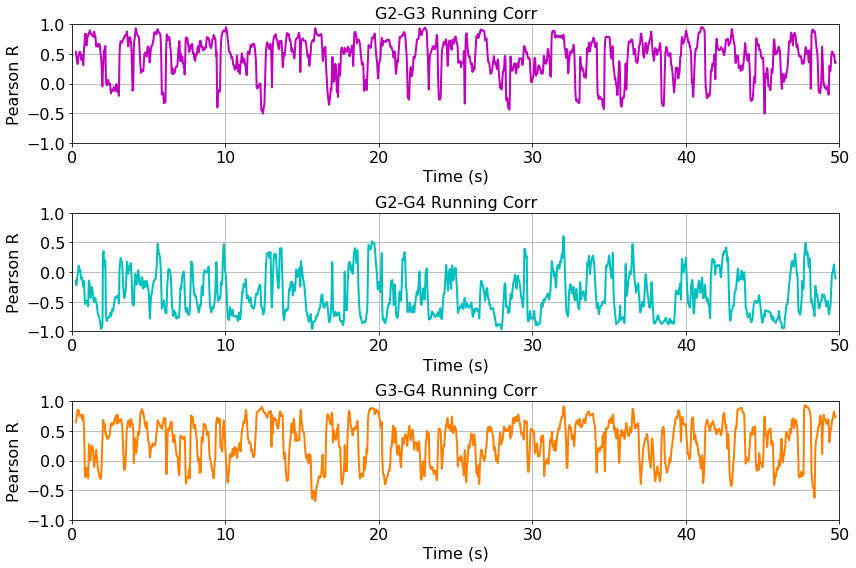

In [2]:
# calc running correlations
WDW_INT = int(round(.5/DT))
mr_23 = np.zeros((n_t-WDW_INT))
mr_24 = np.zeros((n_t-WDW_INT))
mr_34 = np.zeros((n_t-WDW_INT))

for t_start in range(n_t-WDW_INT):
    mr_23[t_start] = pearsonr(*rs[t_start:t_start+WDW_INT, [0, 1]].T)[0]
    mr_24[t_start] = pearsonr(*rs[t_start:t_start+WDW_INT, [0, 2]].T)[0]
    mr_34[t_start] = pearsonr(*rs[t_start:t_start+WDW_INT, [1, 2]].T)[0]
    
fig, axs = plt.subplots(3, 1, figsize=(12, 8), tight_layout=True)
t_mr = t[:-WDW_INT] + (DT*WDW_INT/2)

axs[0].plot(t_mr, mr_23, color='m', lw=2)
axs[0].set_title('G2-G3 Running Corr')
axs[1].plot(t_mr, mr_24, color='c', lw=2)
axs[1].set_title('G2-G4 Running Corr')
axs[2].plot(t_mr, mr_34, color=(1, .5, 0), lw=2)
axs[2].set_title('G3-G4 Running Corr')

for ax in axs:
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Pearson R')
    ax.set_ylim(-1, 1)
    ax.set_xlim(0, t[[-1]])
    set_font_size(ax, 16)
    ax.grid()

# Activity driven by noise + walking speed

In [1]:
%reset -f
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d as smooth
from scipy.signal import resample
from scipy.stats import pearsonr

from disp import set_font_size

EXPT = 'ASENSORY_AZ'
DATA_DIR = os.path.join('data', EXPT)

## Load data and normalize/mask

In [2]:
base = 'BigMAT.csv'
    
trials = []
data_u = {}  # unnormalized data
data_n = {}  # normalized data

for fly in os.listdir(DATA_DIR):
    fly_path = os.path.join(DATA_DIR, fly)
    
    for trial in os.listdir(fly_path):
        trial_path = os.path.join(fly_path, trial)
        
        # load data
        data_u_ = pd.read_csv(os.path.join(trial_path, base))
        
        # select relevant columns
        data_u_ = data_u_[['Time', 'G2_avg', 'G3_avg', 'G4_avg', 'G5_avg', 'Motion', 'ForVel', 'AngVel']]
        data_u_['AbsAngVel'] = np.abs(data_u_['AngVel'])
        data_u_ = data_u_.rename(columns={'G2_avg': 'G2', 'G3_avg': 'G3', 'G4_avg': 'G4', 'G5_avg': 'G5'})
        
        data_u[trial] = data_u_
        
        # normalize data
        data_n_ = data_u_.copy()
        data_n_ -= data_n_.mean()
        data_n_ /= data_n_.std()
        
        # replace normalized time column with original time column
        data_n_['Time'] = data_u_['Time']
        
        data_n[trial] = data_n_
        
        trials.append(trial)

## Drive network with noise + walking motion

/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/scipy/signal/signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/scipy/signal/signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]


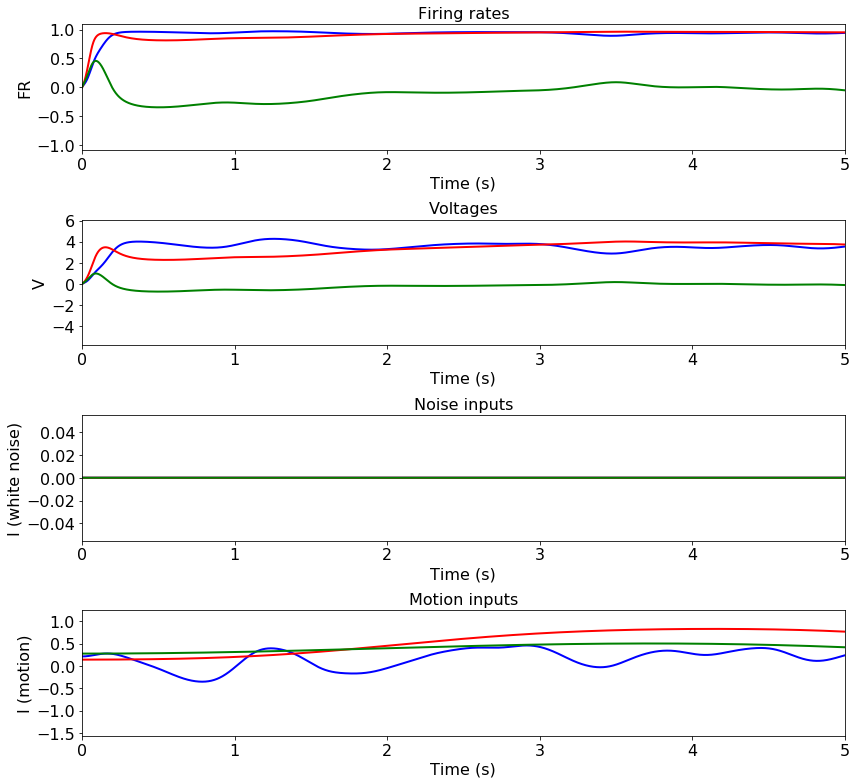

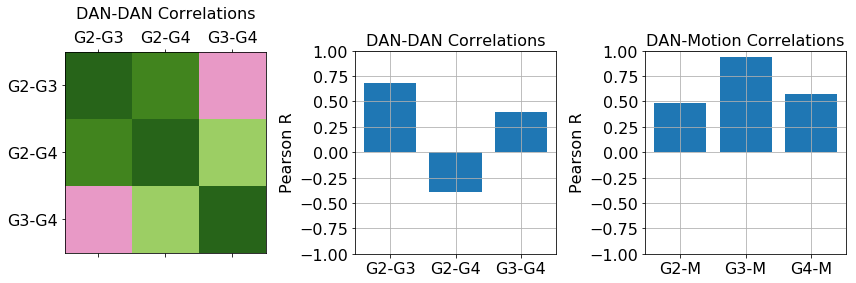

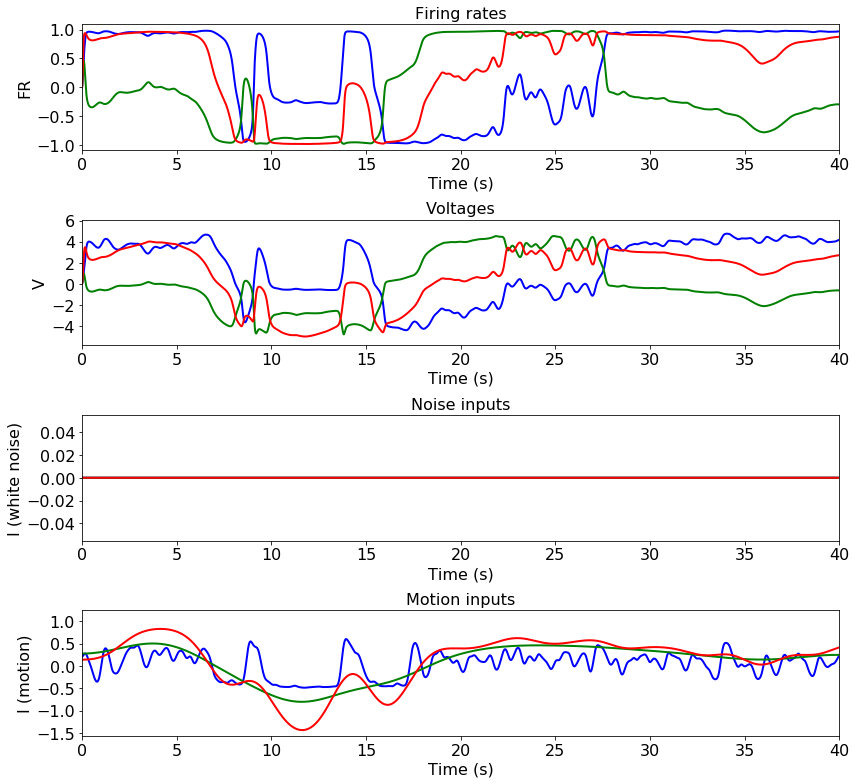

In [3]:
SEED = 0
TRIAL_IDX = 0
MOTION_SCALE = 10

TAU = np.array([0.02, 0.02, 0.02])
W = 3.*np.array([
#from G2 G3 G4
     [0, 1.1, -1.2],  # to G2
     [1.1, 0, 1],   # to G3
     [-1.2, 1, 0],  # to G4
], dtype=float)
G = 1
C = ['b', 'r', 'g']

DT = 0.001  # smln timestep
I_E_SMOOTH_INT = int(round(20*DT/DT))

def phi(x):
    return 2/(1 + np.exp(-x)) - 1

# set up inputs
t_max = np.array(data_n[trials[TRIAL_IDX]]['Time'])[-1]
t = np.arange(0, t_max, DT)
n_t = len(t)

# noise
np.random.seed(SEED)
i_noises = smooth(0*np.random.normal(0, 1, (n_t, 3)), I_E_SMOOTH_INT, axis=0)

# behavior
motion = np.array(data_n[trials[TRIAL_IDX]]['Motion'])
motion -= np.nanmean(motion)
motion /= np.nanstd(motion)
motion *= MOTION_SCALE

i_behavs = np.zeros(i_noises.shape)
# drive G2,3,4 with upsampled motion
i_behavs[:, 0] = smooth(.03*resample(motion, n_t), 100)
i_behavs[:, 1] = smooth(.1*resample(motion, n_t), 1000)
i_behavs[:, 2] = smooth(.085*resample(motion, n_t), 2000)

i_es = i_noises + i_behavs

# run smln
vs = np.nan * np.zeros((n_t, 3))
rs = np.nan * np.zeros((n_t, 3))

vs[0, :] = 0
rs[0, :] = 0

for ctr, i_e in zip(range(1, n_t), i_es[:-1]):
    v = vs[ctr-1]
    dv = DT/TAU * (-v + W.dot(rs[ctr-1]) + i_e)
    vs[ctr] = v + dv
    rs[ctr] = phi(G*vs[ctr])

fig, axs = plt.subplots(4, 1, figsize=(12, 11), tight_layout=True)
#axs[3].plot(data_n[trials[TRIAL_IDX]]['Time'], motion, c='k', lw=4)

for dan in range(3):
    axs[0].plot(t, rs[:, dan], C[dan], lw=2)
    axs[1].plot(t, vs[:, dan], C[dan], lw=2)
    axs[2].plot(t, i_noises[:, dan], C[dan], lw=2)
    axs[3].plot(t, i_behavs[:, dan], C[dan], lw=2)

axs[0].set_title('Firing rates')
axs[0].set_ylabel('FR')
axs[1].set_title('Voltages')
axs[1].set_ylabel('V')
axs[2].set_title('Noise inputs')
axs[2].set_ylabel('I (white noise)')
axs[3].set_title('Motion inputs')
axs[3].set_ylabel('I (motion)')

for ax in axs:
    ax.set_xlim(0, 5)
    ax.set_xlabel('Time (s)')
    set_font_size(ax, 16)
    
# analysis
xcor = np.corrcoef(rs.T)
r_23 = xcor[0, 1]
r_24 = xcor[0, 2]
r_34 = xcor[1, 2]

r_2m = np.corrcoef([rs[:, 0], i_behavs[:, 1]])[0, 1]
r_3m = np.corrcoef([rs[:, 1], i_behavs[:, 1]])[0, 1]
r_4m = np.corrcoef([rs[:, 2], i_behavs[:, 1]])[0, 1]

fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
axs[0].matshow(xcor, interpolation='nearest', cmap='PiYG', vmin=-.8, vmax=.8)
axs[0].set_xticks([0, 1, 2])
axs[0].set_yticks([0, 1, 2])
axs[0].set_xticklabels(['G2-G3', 'G2-G4', 'G3-G4'])
axs[0].set_yticklabels(['G2-G3', 'G2-G4', 'G3-G4'])
axs[0].set_title('DAN-DAN Correlations\n')

axs[1].bar(np.arange(3), [r_23, r_24, r_34])
axs[1].set_ylim(-1, 1)
axs[1].set_ylabel('Pearson R')
axs[1].set_xticks([0, 1, 2])
axs[1].set_xticklabels(['G2-G3', 'G2-G4', 'G3-G4'])
axs[1].set_title('DAN-DAN Correlations')
axs[1].grid()

axs[2].bar(np.arange(3), [r_2m, r_3m, r_4m])
axs[2].set_ylim(-1, 1)
axs[2].set_ylabel('Pearson R')
axs[2].set_xticks([0, 1, 2])
axs[2].set_xticklabels(['G2-M', 'G3-M', 'G4-M'])
axs[2].set_title('DAN-Motion Correlations')
axs[2].grid()

for ax in axs:
    set_font_size(ax, 16)
    
fig, axs = plt.subplots(4, 1, figsize=(12, 11), tight_layout=True)
#axs[3].plot(data_n[trials[TRIAL_IDX]]['Time'], motion, c='k', lw=4)

for dan in [0, 2, 1]:
    axs[0].plot(t, rs[:, dan], C[dan], lw=2)
    axs[1].plot(t, vs[:, dan], C[dan], lw=2)
    axs[2].plot(t, i_noises[:, dan], C[dan], lw=2)
    axs[3].plot(t, i_behavs[:, dan], C[dan], lw=2)

axs[0].set_title('Firing rates')
axs[0].set_ylabel('FR')
axs[1].set_title('Voltages')
axs[1].set_ylabel('V')
axs[2].set_title('Noise inputs')
axs[2].set_ylabel('I (white noise)')
axs[3].set_title('Motion inputs')
axs[3].set_ylabel('I (motion)')

for ax in axs:
    ax.set_xlim(0, 40)
    ax.set_xlabel('Time (s)')
    set_font_size(ax, 16)

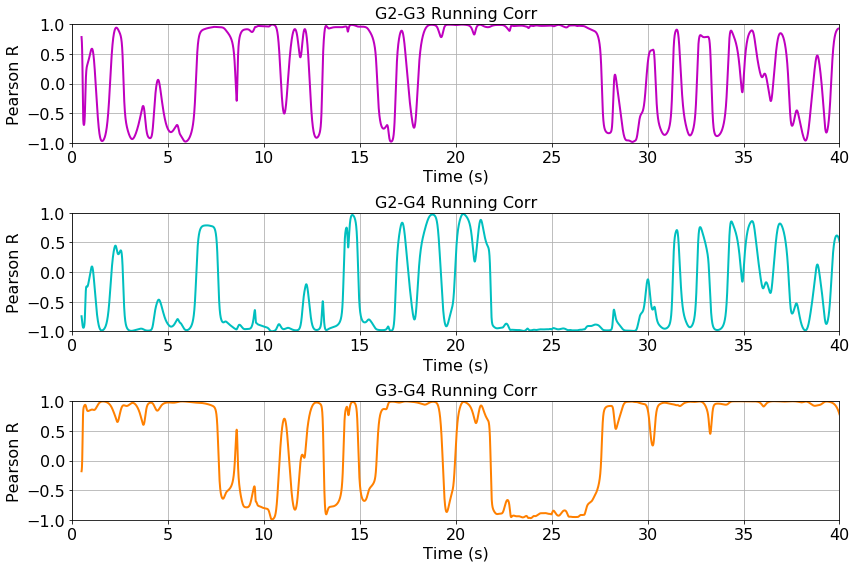

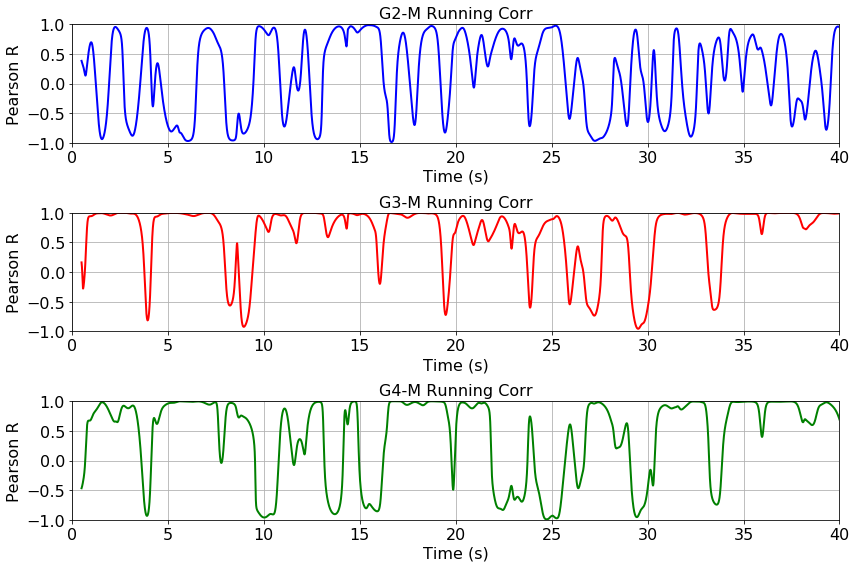

In [4]:
# calc running correlations
WDW_INT = int(round(1/DT))
mr_23 = np.zeros((n_t-WDW_INT))
mr_24 = np.zeros((n_t-WDW_INT))
mr_34 = np.zeros((n_t-WDW_INT))

mr_2m = np.zeros((n_t-WDW_INT))
mr_3m = np.zeros((n_t-WDW_INT))
mr_4m = np.zeros((n_t-WDW_INT))

for t_start in range(n_t-WDW_INT):
    mr_23[t_start] = pearsonr(*rs[t_start:t_start+WDW_INT, [0, 1]].T)[0]
    mr_24[t_start] = pearsonr(*rs[t_start:t_start+WDW_INT, [0, 2]].T)[0]
    mr_34[t_start] = pearsonr(*rs[t_start:t_start+WDW_INT, [1, 2]].T)[0]
    
    mr_2m[t_start] = pearsonr(rs[t_start:t_start+WDW_INT, 0], i_behavs[t_start:t_start+WDW_INT, 1])[0]
    mr_3m[t_start] = pearsonr(rs[t_start:t_start+WDW_INT, 1], i_behavs[t_start:t_start+WDW_INT, 1])[0]
    mr_4m[t_start] = pearsonr(rs[t_start:t_start+WDW_INT, 2], i_behavs[t_start:t_start+WDW_INT, 1])[0]
    
fig, axs = plt.subplots(3, 1, figsize=(12, 8), tight_layout=True)
t_mr = t[:-WDW_INT] + (DT*WDW_INT/2)

axs[0].plot(t_mr, mr_23, color='m', lw=2)
axs[0].set_title('G2-G3 Running Corr')
axs[1].plot(t_mr, mr_24, color='c', lw=2)
axs[1].set_title('G2-G4 Running Corr')
axs[2].plot(t_mr, mr_34, color=(1, .5, 0), lw=2)
axs[2].set_title('G3-G4 Running Corr')

for ax in axs:
    ax.set_xlim(0, 40)
    ax.set_ylim(-1, 1)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Pearson R')
    set_font_size(ax, 16)
    ax.grid()
    
fig, axs = plt.subplots(3, 1, figsize=(12, 8), tight_layout=True)
t_mr = t[:-WDW_INT] + (DT*WDW_INT/2)

axs[0].plot(t_mr, mr_2m, color=C[0], lw=2)
axs[0].set_title('G2-M Running Corr')
axs[1].plot(t_mr, mr_3m, color=C[1], lw=2)
axs[1].set_title('G3-M Running Corr')
axs[2].plot(t_mr, mr_4m, color=C[2], lw=2)
axs[2].set_title('G4-M Running Corr')

for ax in axs:
    ax.set_xlim(0, 40)
    ax.set_ylim(-1, 1)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Pearson R')
    set_font_size(ax, 16)
    ax.grid()